# Importing Libraries

In [ ]:
!python -m pip install --upgrade pip
!pip install numpy
!pip install pandas
!pip install seaborn
!pip install matplotlib
!pip install plotly
!pip install sklearn
!pip install xgboost

In [72]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import warnings

# %matplotlib inline
warnings.filterwarnings('ignore')

# Importing Data

In [73]:
data = pd.read_csv('diabetes.csv')

In [74]:
data.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive


In [75]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Age                 520 non-null    int64 
 1   Gender              520 non-null    object
 2   Polyuria            520 non-null    object
 3   Polydipsia          520 non-null    object
 4   sudden weight loss  520 non-null    object
 5   weakness            520 non-null    object
 6   Polyphagia          520 non-null    object
 7   Genital thrush      520 non-null    object
 8   visual blurring     520 non-null    object
 9   Itching             520 non-null    object
 10  Irritability        520 non-null    object
 11  delayed healing     520 non-null    object
 12  partial paresis     520 non-null    object
 13  muscle stiffness    520 non-null    object
 14  Alopecia            520 non-null    object
 15  Obesity             520 non-null    object
 16  class               520 no

<AxesSubplot:xlabel='class', ylabel='Age'>

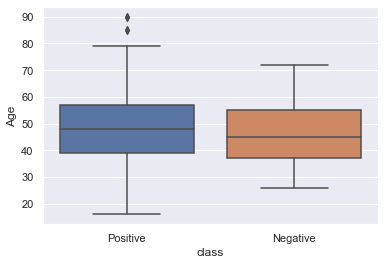

In [76]:
sns.boxplot(x='class',y='Age',data=data)

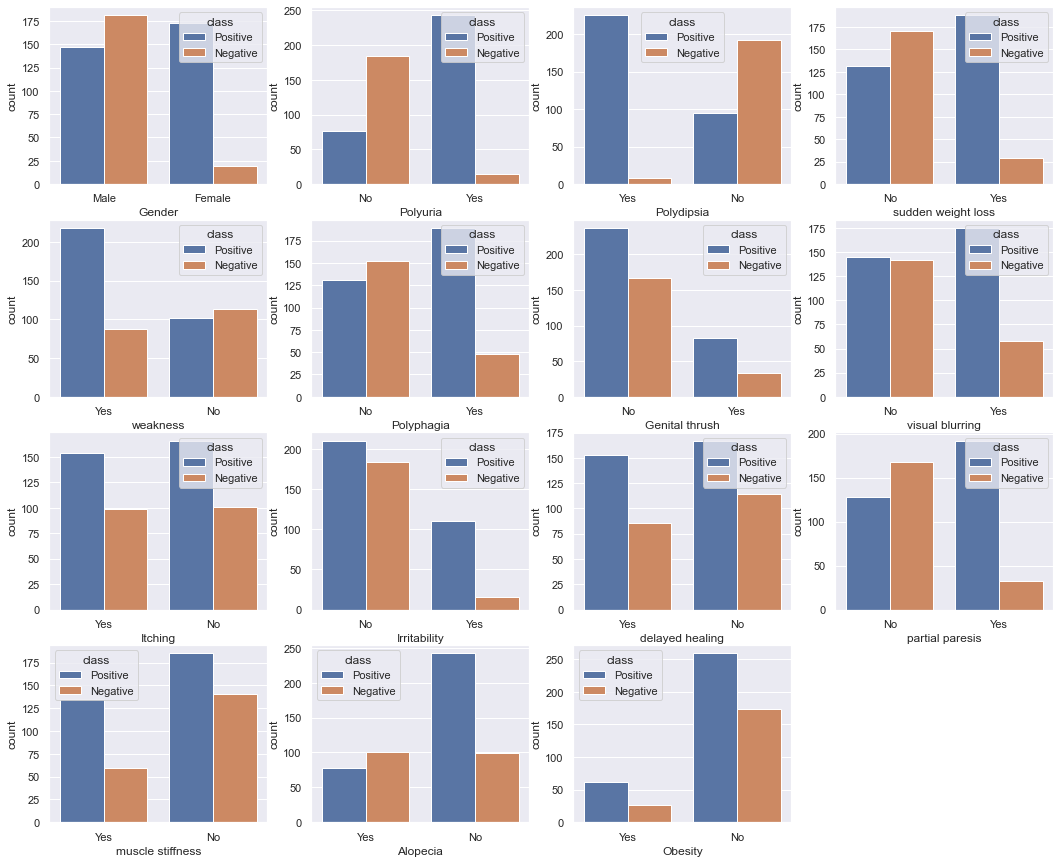

In [77]:
plt.figure(figsize=(18,15))
m=1
for i in data.columns[1:-1]:
    plt.subplot(4,4,m)
    m+=1
    sns.countplot(x=i,data=data,hue='class')

# One Hot Encoding

In [79]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
for i in data.columns[1:]:
    data[i] = label_encoder.fit_transform(data[i])

<AxesSubplot:>

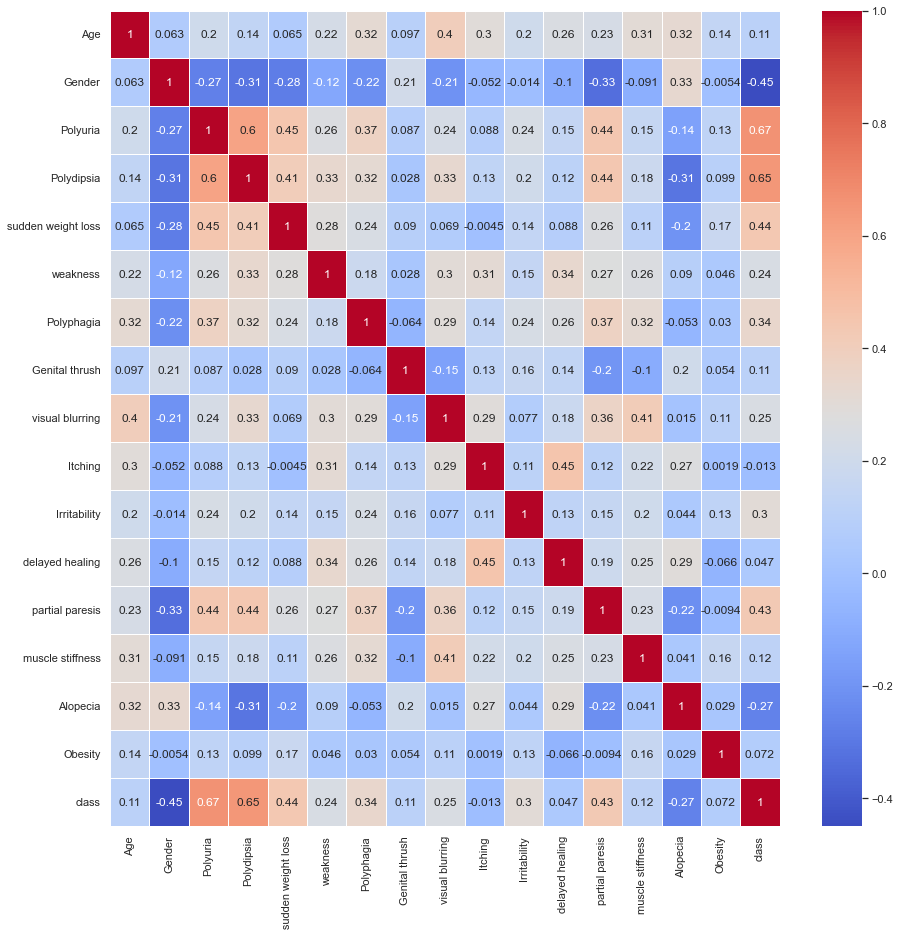

In [80]:
sns.set(font_scale=1)
plt.figure(figsize = (15,15))
sns.heatmap(data.corr(),cmap='coolwarm',annot=True,linewidths=.5)

# Feature selection

In [81]:
X = data.drop('class',axis=1)
Y = data['class']

,Scores,Importance (%)
Feature,,
Polydipsia,120.785515,22.198
Polyuria,116.184593,21.353
sudden weight loss,57.749309,10.613
partial paresis,55.314286,10.166
Gender,38.747637,7.121
Irritability,35.334127,6.494
Polyphagia,33.198418,6.101
Alopecia,24.402793,4.485
Age,18.845767,3.464


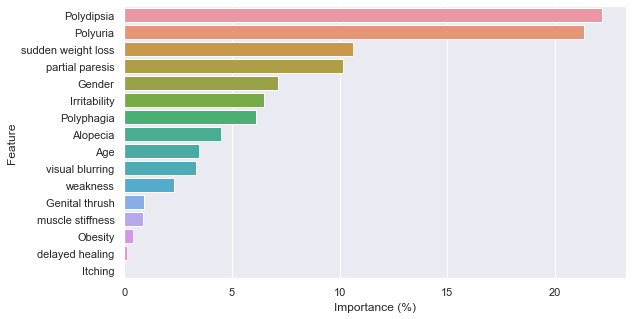

In [82]:
from sklearn.feature_selection import SelectKBest, chi2
fs = SelectKBest(score_func=chi2, k='all')
fs.fit(X, Y)
per = []
for i in fs.scores_:
    per.append(round(((i/sum(fs.scores_))*100),3))

features_data = pd.DataFrame({'Feature':X.columns,'Scores':fs.scores_,'Importance (%)':per}).sort_values(by=['Scores'],ascending=False)

plt.figure(figsize=(9,5))
sns.barplot( 'Importance (%)','Feature',orient='h',data=features_data)
insignificant = features_data.loc[features_data['Importance (%)']<0.005]['Feature'].unique()
features_data.set_index('Feature')

# Test Train Split

In [83]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=100)

# Model Selection

In [84]:
from sklearn.metrics import accuracy_score,classification_report

#XGB
import xgboost as xgb
from xgboost import XGBClassifier
xgb = XGBClassifier() 


# Logistic Regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

#RFC
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()

#KNN
from sklearn.neighbors import KNeighborsClassifier
accuracy = []
for i in range(1,40):    
    kn = KNeighborsClassifier(n_neighbors=i)
    kn.fit(X_train,Y_train)
    predK = kn.predict(X_test)
    accuracy.append([accuracy_score(Y_test,predK),i])
    #print('Tested for k =',i)
temp = accuracy[0]
for m in accuracy:
    if temp[0] < m[0]:
        temp=m
knn = KNeighborsClassifier(n_neighbors=temp[1])

#SVM
from sklearn.svm import SVC
svc = SVC()

from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.1,1, 10, 100, 1000,2000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']} 
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=3)


In [85]:
model_acc = []
models = [xgb,lr,rfc,knn,svc,grid]
for i in models:
    i.fit(X_train,Y_train)
    model_acc.append(accuracy_score(Y_test,i.predict(X_test)))
                      
models = pd.DataFrame({'Models':models,'Accuracy':model_acc})

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.619 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.614 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.602 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.602 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.614 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.667 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.687 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.687 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.651 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.651 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.595 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

In [86]:
models = models.sort_values(by=['Accuracy'],ascending=False).reset_index().drop('index',axis=1)
best = models['Models'][0]
models['Models']=models['Models'].astype(str).str.split("(", n = 2, expand = True)[0]
models

,Models,Accuracy
0,RandomForestClassifier,0.971154
1,GridSearchCV,0.961538
2,LogisticRegression,0.951923
3,XGBClassifier,0.942308
4,KNeighborsClassifier,0.913462
5,SVC,0.673077


In [87]:
print('Hence the best model is',models['Models'][0],'with an accuracy of',round((models['Accuracy'][0]*100),2),'%')
print('\nThe classification report is:')
print(classification_report(Y_test,best.predict(X_test)))

Hence the best model is RandomForestClassifier with an accuracy of 97.12 %

The classification report is:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96        34
           1       0.99      0.97      0.98        70

    accuracy                           0.97       104
   macro avg       0.96      0.97      0.97       104
weighted avg       0.97      0.97      0.97       104

